Be sure to install the dependencies:
```bash
conda install --yes msmbuilder pandas matplotlib seaborn scikit-learn
```
`msmbuilder` was just updated on 19 Oct 2016, so you might want to reinstall:
```bash
conda uninstall --yes scikit-learn msmbuilder
conda clean -pltis --yes
conda install --yes msmbuilder
```

In [75]:
%matplotlib inline

In [76]:
import matplotlib as mpl
mpl.use('Agg')
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import pandas as pd

In [77]:
def read_patient_data(patient):
    filename = '%s_gordon.taxa_count.sorted.txt' % patient

    # Load data
    df = pd.read_table(filename, delim_whitespace=True)

    # Extract sorted sample labels
    samples = list(df.index)
    nsamples = len(samples)

    # Extract feature names
    features = list(df.columns)
    nfeatures = len(features)

    # Extract feature vectors
    patient_timeseries = df.as_matrix()

    return [samples, features, patient_timeseries]

Projecting all patient data...
Making figures...


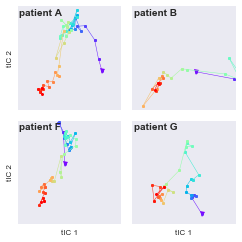

In [95]:
#
# Analyze
#

import msmbuilder.cluster
import msmbuilder.hmm
import sklearn.cluster
from msmbuilder.decomposition import tICA

n_components = 2 # number of dimensions to retain
lag_time = 1 # lag time (in sampling intervals)

#
# Perform tICA clustering on each depth separately
#

# Get colormap
from matplotlib.pyplot import cm

# Construct a tICA projection from all data.
print('Projecting all patient data...')
patients = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
data = list()
for (subplot_index, patient) in enumerate(patients):
    # Load patient data
    [samples, features, patient_timeseries] = read_patient_data(patient)
    data.append(patient_timeseries)
    nsamples = len(samples)
    nfeatures = len(features)
# Create tICA projection and retrieve projected data
tica = tICA(n_components=n_components, lag_time=lag_time)
projected_data = tica.fit_transform(data)

# Make plots
print('Making figures...')
fig = plt.figure(figsize=[3.5,3.5])
subplot_nx = 2
subplot_ny = 2
axis_label_fontsize = 8 # font size for axes labels
subplot_label_fontsize = 10 # font size for patient labels
patient_indices_to_plot = [0, 1, 5, 6]
for (plot_index, patient_index) in enumerate(patient_indices_to_plot):    
    patient = patients[patient_index]
    plot_column = plot_index % subplot_ny
    plot_row = plot_index / subplot_ny
    
    # Load patient data
    [samples, features, patient_timeseries] = read_patient_data(patient)
    nsamples = len(samples)
    nfeatures = len(features)
    projection = projected_data[patient_index]
    cmap = cm.rainbow(np.linspace(0,1,nsamples))
    
    ax = plt.subplot(subplot_ny, subplot_nx, plot_index+1)
    ax.set_color_cycle(cmap)
        
    # Compute tICA projection
    # NOTE: This sometimes failes because of missing values, so this is in a try...except clause
    #tica = tICA(n_components=n_components, lag_time=lag_time)
    #projection = tica.fit_transform([patient_timeseries])
    
    # Print eigenvalues
    #print('eigenvalues:')
    #print tica.eigenvalues_
    #projection = projection[0] # select out only trajectory

    # Plot with time-varying color
    projection = projected_data[patient_index]
    ax.plot(projection[0,0], projection[0,1], 'v', markersize=5);
    for i in range(nsamples-1):
        ax.plot(projection[i:i+2,0], projection[i:i+2,1], 'o-', markersize=3, linewidth=0.5);
    
    # Fix up axes.
    if plot_column == 0:
        plt.ylabel('tIC 2', fontsize=axis_label_fontsize)
    if plot_row == (subplot_ny-1):
        plt.xlabel('tIC 1', fontsize=axis_label_fontsize)
    plt.xticks([])
    plt.yticks([])

    # Add a circle to around endpoint
    # Couldn't figure out how to get this to work
    #mpl.patches.Circle(projection[-1,:], radius=1)
    
    # Make sure axes are equal among all plots
    plt.axis('square')
    plt.axis([-2, +2, -2, +2])
    
    # Label with patient index
    ax.text(-1.95, +1.65,  'patient %s' % patient, fontsize=subplot_label_fontsize, fontweight='bold')

plt.tight_layout()
plt.savefig('panel.pdf')

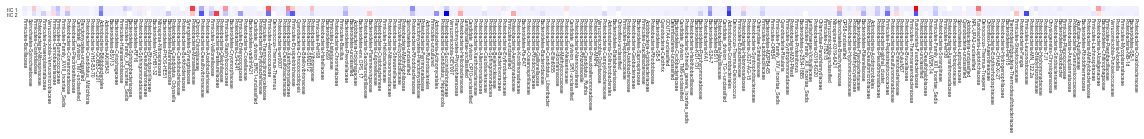

In [96]:
# Plot tICs

def scaledimage(W, pixwidth=1, ax=None, grayscale=False, figsize=[20,3]):
    """
    Do intensity plot, similar to MATLAB imagesc()
    W = intensity matrix to visualize
    pixwidth = size of each W element
    ax = matplotlib Axes to draw on 
    grayscale = use grayscale color map
    Rely on caller to .show()
    
    Code from: https://gist.github.com/davidandrzej/940072
    
    """
    import numpy as NP
    import matplotlib.pyplot as P
    import matplotlib.ticker as MT
    import matplotlib.cm as CM

    # N = rows, M = column
    (N, M) = W.shape 
    # Need to create a new Axes?
    if(ax == None):
        ax = P.figure(figsize=figsize).gca()
    # extents = Left Right Bottom Top
    exts = (0, pixwidth * M, 0, pixwidth * N)
    if(grayscale):
        ax.imshow(W,
                  interpolation='nearest',
                  cmap=CM.gray,
                  extent=exts)
    else:
        ax.imshow(W,
                  interpolation='nearest',
                  cmap=CM.bwr,
                  extent=exts)

    ax.xaxis.set_major_locator(MT.NullLocator())
    ax.yaxis.set_major_locator(MT.NullLocator())
    return ax

scaledimage(tica.eigenvectors_.T, pixwidth=1);
plt.text(-3,1,'tIC 1', fontsize=5);
plt.text(-3,0,'tIC 2', fontsize=5);
for (feature_index, feature) in enumerate(features):
    plt.text(feature_index, -1, feature, rotation=-90, fontsize=5)
plt.savefig('tICs.pdf');

array([ -1.73307957e-06,   1.11413728e-06,   3.00483429e-05,
         6.21577839e-10,   2.65603845e-06,   3.88214495e-06,
        -7.55145834e-06,  -2.12590821e-05,  -7.99963520e-09,
         2.32376329e-05,   2.96842572e-08,  -3.46915642e-07,
        -6.86009256e-07,   8.14107312e-08,   2.15667619e-06,
        -2.82632778e-08,  -3.74137244e-05,   8.73077247e-09,
         1.45480147e-08,   1.10165017e-08,  -5.14701718e-08,
        -1.39113128e-05,  -6.57060666e-06,   1.04001660e-07,
         1.54988255e-05,   3.80220087e-08,   1.17777408e-05,
        -3.33068948e-09,  -1.78734373e-08,   4.00419726e-08,
         7.35630126e-06,   1.77162208e-07,   6.26338292e-07,
         6.36040180e-06,  -2.04921181e-08,   9.13220540e-05,
         3.58527949e-08,  -2.76524694e-05,   3.36543269e-09,
        -9.06299364e-06,   3.29713548e-06,   1.28920682e-07,
         5.08841714e-05,   2.42295332e-06,  -1.89482290e-08,
         8.06127898e-06,  -1.63545957e-07,   8.62191386e-09,
        -6.71159034e-07,